# We firstly import the data of Microsoft, Google, Amazon and Tesla from Yahoo finance

In [1]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas_datareader.data as web
import datetime
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# we plan to evaluate the 2-year data 
start = datetime.datetime(2020,5,23)
end = datetime.datetime(2022,5,23)

In [4]:
# a function to read a single stock
def get_stock(ticker):
    data = web.DataReader(f"{ticker}","yahoo",start,end)
    data[f'{ticker}'] = data["Adj Close"]
    data = data[[f'{ticker}']] 
    print(data.head())
    return data 

In [5]:
from functools import reduce

# a function to read different stocks and combine them into a single table
def combine_stocks(tickers):
    data_frames = []
    for i in tickers:
        data_frames.append(get_stock(i))
        
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
    print(df_merged.head())
    return df_merged


# call the function and generate a table with stock adjusted close prices
stocks = ["MSFT", "GOOGL", "AMZN","TSLA"]
portfolio=combine_stocks(stocks)

                  MSFT
Date                  
2020-05-26  177.494293
2020-05-27  177.728897
2020-05-28  177.328094
2020-05-29  179.136566
2020-06-01  178.725983
                GOOGL
Date                 
2020-05-26  71.068497
2020-05-27  71.014000
2020-05-28  70.912003
2020-05-29  71.676003
2020-06-01  71.743500
                  AMZN
Date                  
2020-05-26  121.093002
2020-05-27  120.519501
2020-05-28  120.055000
2020-05-29  122.118500
2020-06-01  123.552002
                 TSLA
Date                 
2020-05-26  54.591331
2020-05-27  54.681999
2020-05-28  53.720669
2020-05-29  55.666668
2020-06-01  59.873333
                  MSFT      GOOGL        AMZN       TSLA
Date                                                    
2020-05-26  177.494293  71.068497  121.093002  54.591331
2020-05-27  177.728897  71.014000  120.519501  54.681999
2020-05-28  177.328094  70.912003  120.055000  53.720669
2020-05-29  179.136566  71.676003  122.118500  55.666668
2020-06-01  178.725983  71.7

In [6]:
# store the price dataset into computer
portfolio.to_csv("portfolio.csv", index=True)

portfolio = pd.read_csv("portfolio.csv")

portfolio

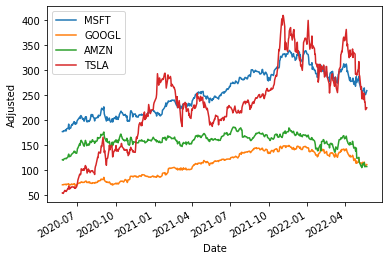

In [7]:
# plot the price within past 2 years
import matplotlib.pyplot as plt
portfolio.plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.show()

# Mean-Variance Portfolio building

Method 1: We use package for the first trial

In [8]:
pip install PyPortfolioOpt

Note: you may need to restart the kernel to use updated packages.


In [9]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
# calculate the expected return using historical data
mu = mean_historical_return(portfolio, returns_data=False)
# calculate the covariance matrix
S = CovarianceShrinkage(portfolio).ledoit_wolf()

mu

S

In [13]:
from pypfopt.efficient_frontier import EfficientFrontier

# generate the efficient frontier
ef = EfficientFrontier(mu,S)

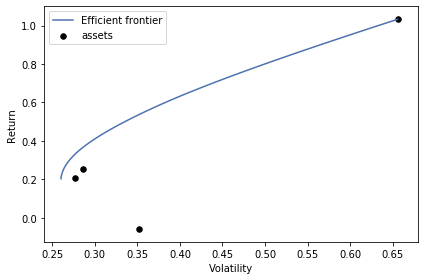

In [11]:
from pypfopt import plotting
# plot the efficient frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef,ax=ax,show_assets=True)
#plt.show()

In [14]:
# maximize sharpe ratio to help us get the portfolio weights
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'MSFT': 0.0, 'GOOGL': 0.28448, 'AMZN': 0.0, 'TSLA': 0.71552}


The optimal portfolio asks us to assign weights of 28% and 72% to google and tesla stocks respectively whereas
microsoft and amazon occupies 0 weight, indicating one of the weakness of mean-variance portfolio that extremal weights are assigned (weight concentrated on only several stocks).

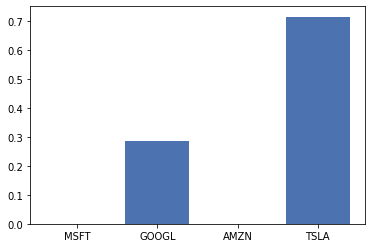

In [15]:
#import matplotlib.pyplot as plt
# plot the bar chart of the weights
plt.bar(dict(cleaned_weights).keys(),dict(cleaned_weights).values() , align='center')
plt.show() 

In [16]:
# performance of the portfolio
ef.portfolio_performance(verbose=True)

Expected annual return: 81.1%
Annual volatility: 50.7%
Sharpe Ratio: 1.56


(0.8110231498630539, 0.5065058696887689, 1.5617255340971892)

In [17]:
# a strategy
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(portfolio)

# assume we have $100000 to purchase portfolio
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'TSLA': 318, 'GOOGL': 255}
Funds remaining: $31.16


Method 2: try to code without using package

In [18]:
# try to create a table of returns
df=pd.DataFrame(columns=portfolio.columns)
for i in df:
    df[i]=portfolio[i].pct_change()

In [19]:
import numpy as np

# for the case when there's no risk-free stock
def get_ret_and_cov(df, frequency):
    """
       frequency is 252 for daily data; 52 for weekly data; 12 for montly data
    """
    ret_ave = pd.DataFrame(df.mean()).reset_index()
    ret_ave.columns = ['Stkcd', 'ret_ave']
    # annualize return rate
    ret_ave['ret_ave'] = ret_ave['ret_ave'] * frequency
    ret_std = pd.DataFrame(df.std()).reset_index()
    ret_std.columns = ['Stkcd', 'ret_std']
    ret_std['ret_std'] = ret_std['ret_std'] * np.sqrt(frequency)
    # annualize covariance
    ret_cov = df.cov()
    ret_cov = df.cov() * frequency
    return ret_ave, ret_std, ret_cov

def mini_vol(number, ret_ave_vector, ret_cov_matrix, target_ret):
    """number is stock numbers；ret_ave_vector is the return column vector;
       ret_cov_matrix is the return covariance matrix
       target_ret is target return
    """
    # reverse the covariance matrix
    ret_cov_matrix_I = ret_cov_matrix.I
    # l=[1,1,1,1]
    l = np.matrix([1]*number).reshape((-1,1))
    # 4*4 matrix: multiply the matrixs we have alpha, beta, gamma
    a = float(np.dot(np.dot(ret_ave_vector.T,  ret_cov_matrix_I), ret_ave_vector))
    b = float(np.dot(np.dot(l.T, ret_cov_matrix_I), ret_ave_vector))
    c = float(np.dot(np.dot(l.T, ret_cov_matrix_I), l))
    
    #weights=np.dot(((a-np.dot(b,y1))/(np.dot(c,a)-np.dot(b,b)),ret_cov_matrix_I),l)+np.dot(((np.dot(c,y1)-b)/(np.dot(c,a)-np.dot(b,b)),ret_cov_matrix_I),ret_ave_vector)

    # get coefficient matrix
    coeff_matrix = np.matrix([a,b,b,c]).reshape((2,2))
    coeff_matrix_I = coeff_matrix.I
    # solve lambdas
    y1 = np.matrix([target_ret, 1]).reshape((-1,1))
    #lambda_result = np.dot(coeff_matrix_I, y1)
    #lambda1 = float(lambda_result[0])
    #lambda2 = float(lambda_result[1])
    # calculate weights
    #lambda1=(a-np.dot(b,y1))/(np.dot(c,a)-np.dot(b,b))
    #lambda2=(np.dot(c,y1)-b)/(np.dot(c,a)-np.dot(b,b))
    lambda1=(a-b*target_ret)/(c*a-b*b)
    lambda2=(c*target_ret-b)/(c*a-b*b)
    #weights=np.dot(((a-np.dot(b,y1))/(np.dot(c,a)-np.dot(b,b)),ret_cov_matrix_I),l)+np.dot(((np.dot(c,y1)-b)/(np.dot(c,a)-np.dot(b,b)),ret_cov_matrix_I),ret_ave_vector)


    weights = lambda2 * np.dot(ret_cov_matrix_I, ret_ave_vector) + lambda1 * np.dot(
                ret_cov_matrix_I, l)
    #variance=(np.dot(c,y1,y1)-2*np.dot(b,y1)+a)/(np.dot(c,a)-np.dot(b,b))
    return weights

def port_info(weights, ret_ave_vector, ret_cov_matrix):
    """annualized return rate and volatility"""
    port_return =  float(np.dot(weights.T, ret_ave_vector))
    port_var = float(np.dot(np.dot(weights.T, ret_cov_matrix),weights))
    port_std = np.sqrt(port_var)
    return port_return, port_std


ret_ave, ret_std, ret_cov = get_ret_and_cov(df, 252)
# get return rate vector and covariance matrix
ret_ave1 = np.matrix(ret_ave['ret_ave']).reshape((-1,1))
ret_cov1 = np.matrix(ret_cov)    
# set target return as 0.8 and calculate the optimal weights
weights = mini_vol(4, ret_ave1, ret_cov1, 0.8)
# calculate annualized return and volatility
port_return, port_std = port_info(weights, ret_ave1, ret_cov1)

In [20]:
weights

matrix([[ 0.49796428],
        [ 0.9505304 ],
        [-0.91870321],
        [ 0.47020853]])

In [21]:
port_return

0.8000000000000002

In [22]:
port_std

0.44478019951467945

In [23]:
ret_ave, ret_std, ret_cov

(   Stkcd   ret_ave
 0   MSFT  0.227621
 1  GOOGL  0.265747
 2   AMZN  0.002089
 3   TSLA  0.927189,
    Stkcd   ret_std
 0   MSFT  0.273845
 1  GOOGL  0.283445
 2   AMZN  0.350153
 3   TSLA  0.660167,
            MSFT     GOOGL      AMZN      TSLA
 MSFT   0.074991  0.058656  0.065117  0.090239
 GOOGL  0.058656  0.080341  0.061831  0.074581
 AMZN   0.065117  0.061831  0.122607  0.104263
 TSLA   0.090239  0.074581  0.104263  0.435821)

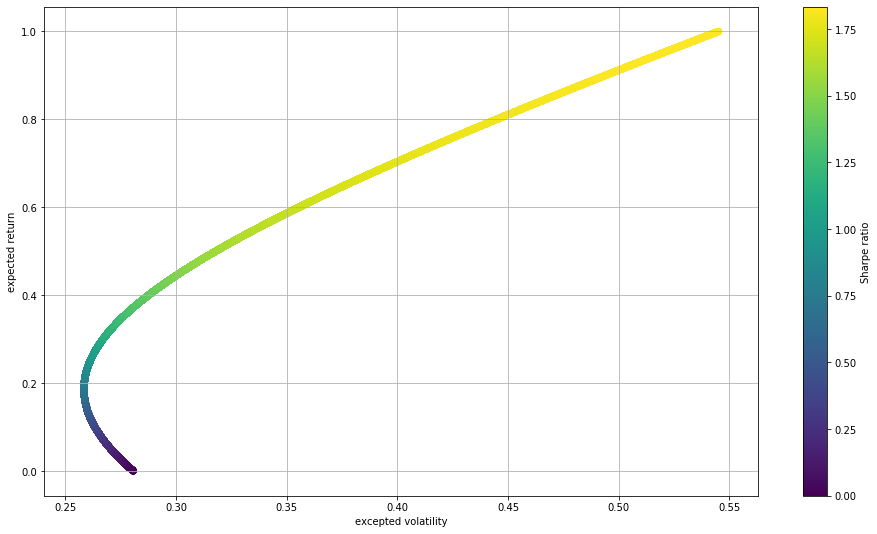

In [24]:
import matplotlib.pyplot as plt

port_ret = []
port_std = []

# plot the efficient frontier and create a dataframe for this
ranges = np.arange(0,1, 0.00001)
for i in ranges:
    weight = mini_vol(4, ret_ave1, ret_cov1, i)
    port_ret1, port_std1 = port_info(weight, ret_ave1, ret_cov1)
    port_ret.append(port_ret1)
    port_std.append(port_std1)

port_std = np.array(port_std)
port_ret = np.array(port_ret)
plt.figure(figsize = (16,9))
plt.scatter(port_std,port_ret,c = port_ret/port_std, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')  

data = {'Returns':port_ret, 'Volatility':port_std}

In [25]:
portfolios=pd.DataFrame(data)

find the optimal portfolio by maximizing the Sharpe's ratio

In [26]:
# Finding the optimal portfolio
# set risk free rate as 0.02
rf = 0.02 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns       0.999990
Volatility    0.545035
Name: 99999, dtype: float64

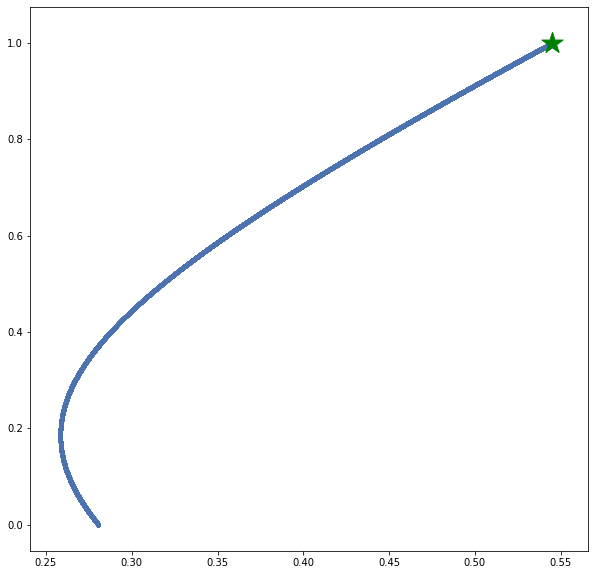

In [27]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)

In [28]:
weights = mini_vol(4, ret_ave1, ret_cov1, 0.999990)
# calculate annualized return and volatility
port_return, port_std = port_info(weights, ret_ave1, ret_cov1)

In [30]:
weights

matrix([[ 0.47613885],
        [ 1.12963785],
        [-1.24644176],
        [ 0.64066506]])

sell short?

In [31]:
port_return

0.9999899999999999

In [32]:
port_std

0.5450349844836315

# Risk-parity portfolio

Method 1: using package to establish the portfolio

In [42]:
df.cov()

,MSFT,GOOGL,AMZN,TSLA
MSFT,0.000298,0.000233,0.000258,0.000358
GOOGL,0.000233,0.000319,0.000245,0.000296
AMZN,0.000258,0.000245,0.000487,0.000414
TSLA,0.000358,0.000296,0.000414,0.001729


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2409818928339733
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
Weights： [[0.29803828 0.30467266 0.2478746  0.14941446]]


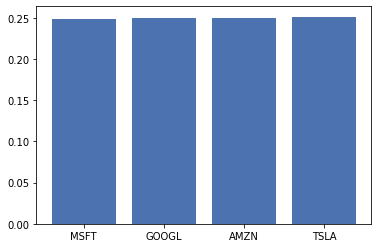

In [43]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
V = np.matrix(df.cov()) # covariance of assets
R = np.matrix(mean_historical_return(portfolio,returns_data=False)) # expected return

def calculate_portfolio_var(w,V):
    # calculate the variability of portfolio
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # calculate the contribution to risk of each asset
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # marginal risk contribution
    MRC = V*w.T/sigma
    # risk contribution = MRC * weight
    RC = np.multiply(MRC,w.T)/sigma  # we need to equalize RC
    return RC

def risk_budget_objective(x,pars):
    V = pars[0]# covariance matrix
    x_t = pars[1] # target risk contribution
    sig_p = np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))  # calculate target risk using portfolio risk and risk contribution
    asset_RC = calculate_risk_contribution(x,V)  # calculate the actual risk contribution
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error, that we need to minimize
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

# calculate weight according to the target risk contribution
def calcu_w(x):
    w0 = [0.2, 0.2, 0.2, 0.6] 
    x_t = x # goal is to equalize the contribution to risk === 0.25 for each of the 4 assets
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})
    w_rb = np.asmatrix(res.x)
    return w_rb

# plot the bar chart for the risk contribution
def plot_rc(w):
    rc = calculate_risk_contribution(w, V)
    rc = rc.tolist()
    rc = [i[0] for i in rc]
    rc = pd.DataFrame(rc,columns=['risk contribution'],index=[1,2,3,4])
    plt.bar(['MSFT','GOOGL','AMZN','TSLA'],rc["risk contribution"], align='center')
    
w_rb = calcu_w([0.25, 0.25, 0.25, 0.25])
print('Weights：', w_rb)
plot_rc(w_rb)

Method 2

In [44]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from scipy.optimize import minimize
TOLERANCE = 1e-10


def _allocation_risk(weights, covariances):

    # We calculate the portfolio risk (sigma^2)
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]  

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the portfolio
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of total portfolio risk
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the portfolio risk (total portfolio variance)
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the portfolio 
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the portfolio
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated/actual contribution of
    # each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error


def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights


def get_weights(yahoo_tickers=['MSFT','GOOGL', 'AMZN', 'TSLA'],
                start_date=datetime.datetime(2020,5,23),
                end_date=datetime.datetime(2022,5,23)):

    # We download the prices from Yahoo Finance
    prices = pd.DataFrame([web.DataReader(t,
                                          'yahoo',
                                          start_date,
                                          end_date).loc[:, 'Adj Close']
                           for t in yahoo_tickers],
                          index=yahoo_tickers).T.asfreq('B').ffill()

    # We calculate the covariance matrix
    #covariances = 252.0 * prices.asfreq('W-FRI').pct_change().iloc[1:, :].cov().values
    covariances=V

    # The desired contribution of each asset to the portfolio risk: we want all
    # asset to contribute equally
    assets_risk_budget = [1 / prices.shape[1]] * prices.shape[1]

    # Initial weights: equally weighted
    #init_weights = [1 / prices.shape[1]] * prices.shape[1]
    init_weights = [0.2, 0.2, 0.2, 0.6] 
    # Optimisation process of weights
    weights =  _get_risk_parity_weights(covariances, assets_risk_budget, init_weights)

    # Convert the weights to a pandas Series
    weights = pd.Series(weights, index=prices.columns, name='weight')

    # It returns the optimised weights
    return weights
get_weights()

MSFT     0.299149
GOOGL    0.304436
AMZN     0.247775
TSLA     0.148640
Name: weight, dtype: float64

Method 3: we calculate the weight in each trading day to equalize the risk contribution of each asset

from math import sqrt
portfolio['MSFT Vol'] = portfolio['MSFT'].rolling(252).std() * sqrt(252)
portfolio['GOOGL Vol'] = portfolio['GOOGL'].rolling(252).std() * sqrt(252)
portfolio['AMZN Vol'] = portfolio['AMZN'].rolling(252).std() * sqrt(252)
portfolio['TSLA Vol'] = portfolio['TSLA'].rolling(252).std() * sqrt(252)

In [34]:
from math import sqrt
portfolio['MSFT Vol'] = df['MSFT'].rolling(252).std() * sqrt(252)
portfolio['GOOGL Vol'] = df['GOOGL'].rolling(252).std() * sqrt(252)
portfolio['AMZN Vol'] = df['AMZN'].rolling(252).std() * sqrt(252)
portfolio['TSLA Vol'] = df['TSLA'].rolling(252).std() * sqrt(252)

In [35]:
# null values are because we do not have 252 days prior to those rows
portfolio.dropna(inplace=True)

portfolio

In [36]:
# set target volatility rate as 0.1
target_vol = 0.10/4
# calculates the allocation to each asset every day by using equalized target volatility dividing by rolling volatility of each asset
portfolio_df = pd.DataFrame({'MSFT Alloc': target_vol/portfolio['MSFT Vol'],
                             'GOOGL Alloc': target_vol/portfolio['GOOGL Vol'],
                             'AMZN Alloc': target_vol/portfolio['AMZN Vol'], 
                             'TSLA Alloc': target_vol/portfolio['TSLA Vol']
                            })
# Now we have the percentage allocation for each asset class on each given day. When the volatility of the asset increases, the allocation to that asset decreases.

In [37]:
# try to create a table of returns
df2=pd.DataFrame(columns=portfolio.columns)
for i in df:
    df2[i]=portfolio[i].pct_change()

In [38]:
# We multiply the daily return data by the allocation percentage on that given day to give us the return for each portion of the portfolio 
portfolio_df['MSFT Return'] = df2['MSFT']*portfolio_df['MSFT Alloc']
portfolio_df['GOOGL Return'] = df2['GOOGL']*portfolio_df['GOOGL Alloc']
portfolio_df['AMZN Return'] = df2['AMZN']*portfolio_df['AMZN Alloc']
portfolio_df['TSLA Return'] = df2['TSLA']*portfolio_df['TSLA Alloc']

In [39]:
#Finally, we add up the returns and calculate the portfolio's daily return
portfolio_df['Portfolio Return'] = portfolio_df['MSFT Return'] + portfolio_df['GOOGL Return'] + portfolio_df['AMZN Return']+ portfolio_df['TSLA Return']


In [40]:
# Creating a hypothetical $1,000 portfolio and calculate the cumulative performance of the risk parity portfolio.
portfolio_df['Portfolio Value'] = ((portfolio_df['Portfolio Return'] + 1).cumprod())*1000

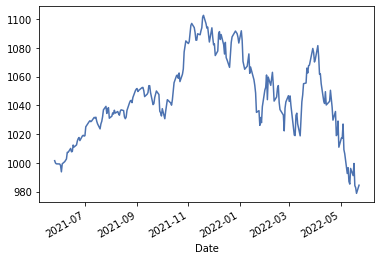

In [41]:
# plot the performance of the portfolio at each day
portfolio_df['Portfolio Value'].plot()
plt.show()

portfolio = pd.read_csv("portfolio.csv")

_allocation_risk(np.matrix([0.29803826, 0.30467268, 0.2478746,0.14941446]),V)

_assets_risk_contribution_to_allocation_risk(np.matrix([0.29803826, 0.30467268, 0.2478746,0.14941446]),V)

# Evaluation of two models

Evaluation of return table

In [45]:
df['Mean_Variance return']=df['GOOGL']*0.28448+df['TSLA']*0.71552
df['Risk-parity return']=df['MSFT']*0.29803826+df['GOOGL']*0.30467268+df['AMZN']*0.2478746+df['TSLA']*0.14941446

In [47]:
mv_mean=np.mean(df['Mean_Variance return'])
rp_mean=np.mean(df['Risk-parity return'])



In [48]:
mv_mean

0.002932625444127314

In [49]:
rp_mean

0.0011422960257018993

Mean-variance portfolio has higher mean return rate than risk-parity portfolio.

In [50]:
new=pd.DataFrame()
new['Mean variance']=df['Mean_Variance return']
new['Risk-parity']=df['Risk-parity return']

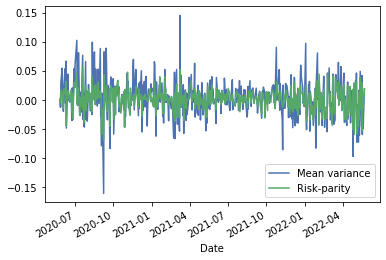

In [51]:
new.plot()

Evaluation of price table

In [52]:
portfolio['Mean_Variance value']=portfolio['GOOGL']*0.28448+portfolio['TSLA']*0.71552
portfolio['Risk-parity value']=portfolio['MSFT']*0.29803826+portfolio['GOOGL']*0.30467268+portfolio['AMZN']*0.2478746+portfolio['TSLA']*0.14941446

In [53]:
mv_mean=np.mean(portfolio['Mean_Variance value'])
rp_mean=np.mean(portfolio['Risk-parity value'])




In [54]:
mv_mean

1379.0238264350814

In [55]:
rp_mean

1837.171220097316

In [56]:
new2=pd.DataFrame()
new2['Mean variance']=portfolio['Mean_Variance value']
new2['Risk-parity']=portfolio['Risk-parity value']

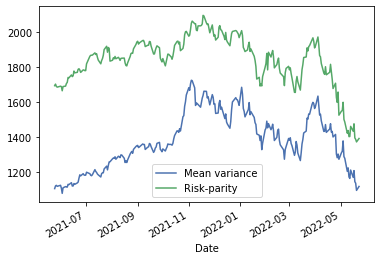

In [57]:
new2.plot()

In [58]:
new2.corr()

,Mean variance,Risk-parity
Mean variance,1.000000,0.684084
Risk-parity,0.684084,1.000000


comparison of Sharpe's ratio

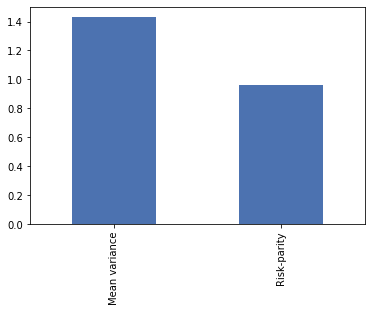

In [59]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 252 #255 trading days in a year
rf =0.01 #1% risk free rate
sharpes = new.apply(sharpe_ratio, args=(N,rf,),axis=0)
sharpes.plot.bar()